# 강화학습 구현과 실현

강화학습에는 여러 기법이 있는데 여기에서는 DQN(Deep Q-Network)를 사용하여 강화학습을 진행하였습니다  
DQN은 기존의 Q-Learning에 신경망을 결합한 것입니다  
Q-Learning은 주어진 상태에서 행동을 수행하면서 미래의 효율적인 기댓값을 예측하는 Q 함수를 학습하면서 최적의 정책을 학습히는 기법입니다  

## 설치

In [5]:
!pip install tensorflow
!pip install matplotlib

zsh:1: command not found: pip
zsh:1: command not found: pip


In [4]:
import tensorflow as tf
import numpy as np
import random
import math
import os
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
#tf.compat.v1.disable_eager_execution()
# tensorflow v2에서 사용법인 바뀐 함수들은 앞에 tf.compat.v1.를 붙여서 사용해준다

epsilon = 1  # 랜덤하게 행동할 확률
epsilonMinimumValue = 0.001  # epsilon의 최소값
nbActions = 3  # 행동의 개수 (왼쪽, 대기, 오른쪽)
epoch = 1001  # 게임 반복횟수
hiddenSize = 100  # 히든 레이어 뉴런 개수
maxMemory = 500  # 게임내용을 기억하는 최대 개수
batchSize = 50  # 학습시 데이터 묶음 개수
gridSize = 10  # 격자 크기
nbStates = gridSize * gridSize  # 상태 개수 (게임화면 픽셀의 개수)
discount = 0.9  # 감소값
learningRate = 0.2  # 학습률

X = tf.compat.v1.placeholder(tf.float32, [None, nbStates]) # 입력값
W1 = tf.Variable(tf.random.truncated_normal([nbStates, hiddenSize], stddev=1.0 / math.sqrt(float(nbStates)))) # 가중치
b1 = tf.Variable(tf.random.truncated_normal([hiddenSize], stddev=0.01)) # 편향
input_layer = tf.nn.relu(tf.matmul(X, W1) + b1) # 출력값

W2 = tf.Variable(tf.random.truncated_normal([hiddenSize, hiddenSize],stddev=1.0 / math.sqrt(float(hiddenSize)))) # 가중치
b2 = tf.Variable(tf.random.truncated_normal([hiddenSize], stddev=0.01)) # 편향
hidden_layer = tf.nn.relu(tf.matmul(input_layer, W2) + b2) # 출력값

W3 = tf.Variable(tf.random.truncated_normal([hiddenSize, nbActions],stddev=1.0 / math.sqrt(float(hiddenSize))))
b3 = tf.Variable(tf.random.truncated_normal([nbActions], stddev=0.01))
output_layer = tf.matmul(hidden_layer, W3) + b3

Y = tf.compat.v1.placeholder(tf.float32, [None, nbActions])

cost = tf.reduce_sum(tf.square(Y-output_layer)) / (2*batchSize)

optimizer = tf.compat.v1.train.GradientDescentOptimizer(learningRate).minimize(cost)

def randf(s, e):
    return (float(random.randrange(0, (e - s) * 9999)) / 10000) + s;

class CatchEnvironment():
    # 초기화
    def __init__(self, gridSize):
        self.gridSize = gridSize
        self.nbStates = self.gridSize * self.gridSize
        self.state = np.empty(3, dtype = np.uint8) 
        
    # 화면정보 리턴
    def observe(self):
        canvas = self.drawState()
        canvas = np.reshape(canvas, (-1,self.nbStates))
        return canvas
    
    # 블럭과 바를 표시하여 화면정보 리턴
    def drawState(self):
        canvas = np.zeros((self.gridSize, self.gridSize))
    
        # 블럭 표시
        canvas[self.state[0]-1, self.state[1]-1] = 1

        # 바 표시
        canvas[self.gridSize-1, self.state[2] -1 - 1] = 1
        canvas[self.gridSize-1, self.state[2] -1] = 1
        canvas[self.gridSize-1, self.state[2] -1 + 1] = 1    
        return canvas 

    # 블럭과 바 위치 초기화
    def reset(self): 
        initialFruitColumn = random.randrange(1, self.gridSize + 1)
        initialBucketPosition = random.randrange(2, self.gridSize + 1 - 1)
        self.state = np.array([1, initialFruitColumn, initialBucketPosition]) 
        return self.getState()

    # 상태 리턴
    def getState(self):
        stateInfo = self.state
        fruit_row = stateInfo[0]
        fruit_col = stateInfo[1]
        basket = stateInfo[2]
        return fruit_row, fruit_col, basket

    # 보상값 리턴
    def getReward(self):
        fruitRow, fruitColumn, basket = self.getState()
        if (fruitRow == self.gridSize - 1):  # If the fruit has reached the bottom.
            if (abs(fruitColumn - basket) <= 1): # Check if the basket caught the fruit.
                return 1
            else:
                return -1
        else:
            return 0

    # 게임오버 검사
    def isGameOver(self):
        if (self.state[0] == self.gridSize - 1): 
            return True 
        else: 
            return False 

    # 상태 업데이트
    def updateState(self, action):
        if (action == 1):
            action = -1  # 왼쪽 이동
        elif (action == 2):
            action = 0  # 대기
        else:
            action = 1  # 오른쪽 이동
        fruitRow, fruitColumn, basket = self.getState()
        newBasket = min(max(2, basket + action), self.gridSize - 1)  # 바 위치 변경
        fruitRow = fruitRow + 1  # 블럭을 아래로 이동
        self.state = np.array([fruitRow, fruitColumn, newBasket])

    # 행동 수행 (1->왼쪽, 2->대기, 3->오른쪽)
    def act(self, action):
        self.updateState(action)
        reward = self.getReward()
        gameOver = self.isGameOver()
        return self.observe(), reward, gameOver, self.getState() 

class ReplayMemory:

    # 초기화
    def __init__(self, gridSize, maxMemory, discount):
        self.maxMemory = maxMemory
        self.gridSize = gridSize
        self.nbStates = self.gridSize * self.gridSize
        self.discount = discount
        canvas = np.zeros((self.gridSize, self.gridSize))
        canvas = np.reshape(canvas, (-1,self.nbStates))
        self.inputState = np.empty((self.maxMemory, 100), dtype = np.float32)
        self.actions = np.zeros(self.maxMemory, dtype = np.uint8)
        self.nextState = np.empty((self.maxMemory, 100), dtype = np.float32)
        self.gameOver = np.empty(self.maxMemory, dtype = np.bool_)
        self.rewards = np.empty(self.maxMemory, dtype = np.int8) 
        self.count = 0
        self.current = 0

    # 게임내용 추가
    def remember(self, currentState, action, reward, nextState, gameOver):
        self.actions[self.current] = action
        self.rewards[self.current] = reward
        self.inputState[self.current, ...] = currentState
        self.nextState[self.current, ...] = nextState
        self.gameOver[self.current] = gameOver
        self.count = max(self.count, self.current + 1)
        self.current = (self.current + 1) % self.maxMemory

    # 게임내용을 배치로 묶어서 리턴
    def getBatch(self, model, batchSize, nbActions, nbStates, sess, X):
        memoryLength = self.count
        chosenBatchSize = min(batchSize, memoryLength)
        inputs = np.zeros((chosenBatchSize, nbStates))
        targets = np.zeros((chosenBatchSize, nbActions))

        for i in range(chosenBatchSize):
            # 메모리에서 랜덤하게 선택
            randomIndex = random.randrange(0, memoryLength)
            current_inputState = np.reshape(self.inputState[randomIndex], (1, 100))
            target = sess.run(model, feed_dict={X: current_inputState})

            current_nextState = np.reshape(self.nextState[randomIndex], (1, 100))
            current_outputs = sess.run(model, feed_dict={X: current_nextState})      

            # 다음 상태의 최대 Q값
            nextStateMaxQ = np.amax(current_outputs)


            if (self.gameOver[randomIndex] == True):
                # 게임오버일때 Q값은 보상값으로 설정
                target[0, [self.actions[randomIndex]-1]] = self.rewards[randomIndex]
            else:
                # Q값을 계산
                # reward + discount(gamma) * max_a' Q(s',a')
                target[0, [self.actions[randomIndex]-1]] = self.rewards[randomIndex] +self.discount * nextStateMaxQ
                
            inputs[i] = current_inputState
            targets[i] = target
        return inputs, targets

def main(_):
    print("Training new model")

    # 환경 정의
    env = CatchEnvironment(gridSize)

    # 메모리 정의
    memory = ReplayMemory(gridSize, maxMemory, discount)

    # 세이버 설정
    saver = tf.compat.v1.train.Saver()
    
    winCount = 0
    with tf.compat.v1.Session() as sess:   
        sess.run(tf.compat.v1.global_variables_initializer())

        for i in range(epoch):
            err = 0
            env.reset()
      
            isGameOver = False

            currentState = env.observe()
            
            while (isGameOver != True):
                action = -9999 

                # 랜덤으로 행동을 할지 Q값에 따라 행동할지 결정
                global epsilon
                if (randf(0, 1) <= epsilon):
                    action = random.randrange(0, nbActions+1)
                else:          
                    q = sess.run(output_layer, feed_dict={X: currentState})          
                    index = q.argmax()
                    action = index + 1  

 

                # 랜덤으로 행동할 확률 감소
                if (epsilon > epsilonMinimumValue):
                  epsilon = epsilon * 0.999
                
                # 행동 수행
                nextState, reward, gameOver, stateInfo = env.act(action)

                # 승리 횟수 설정
                if (reward == 1):
                    winCount = winCount + 1

                # 메모리에 저장
                memory.remember(currentState, action, reward, nextState, gameOver)

                # 다음 상태 설정
                currentState = nextState
                isGameOver = gameOver
                
                # 입력과 출력 데이터 배치를 구함
                inputs, targets = memory.getBatch(output_layer, batchSize, nbActions, nbStates, sess, X)
        
                # 학습 수행
                _, loss = sess.run([optimizer, cost], feed_dict={X: inputs, Y: targets})  
                err = err + loss

            print("Epoch " + str(i) + ": err = " + str(err) + ": Win count = " + str(winCount) + " Win ratio = " + str(float(winCount)/float(i+1)*100))

        # 모델 세션 저장
        save_path = saver.save(sess,'model')

        print("Finish")

if __name__ == '__main__':
    tf.compat.v1.app.run()

Training new model
Epoch 0: err = 0.012051751331455307: Win count = 1 Win ratio = 100.0
Epoch 1: err = 0.08023692993447185: Win count = 2 Win ratio = 100.0
Epoch 2: err = 0.164929891936481: Win count = 2 Win ratio = 66.66666666666666
Epoch 3: err = 0.25315150967799127: Win count = 3 Win ratio = 75.0
Epoch 4: err = 0.2816175948828459: Win count = 3 Win ratio = 60.0
Epoch 5: err = 0.34003081545233727: Win count = 3 Win ratio = 50.0
Epoch 6: err = 0.4904181621968746: Win count = 3 Win ratio = 42.857142857142854
Epoch 7: err = 0.3792357388883829: Win count = 4 Win ratio = 50.0
Epoch 8: err = 0.4676119424402714: Win count = 4 Win ratio = 44.44444444444444
Epoch 9: err = 0.3895579408854246: Win count = 4 Win ratio = 40.0
Epoch 10: err = 0.38229720667004585: Win count = 5 Win ratio = 45.45454545454545
Epoch 11: err = 0.3898044489324093: Win count = 5 Win ratio = 41.66666666666667
Epoch 12: err = 0.3755129985511303: Win count = 6 Win ratio = 46.15384615384615
Epoch 13: err = 0.4264730736613273

Epoch 104: err = 0.23676204308867455: Win count = 40 Win ratio = 38.095238095238095
Epoch 105: err = 0.18427777290344238: Win count = 40 Win ratio = 37.735849056603776
Epoch 106: err = 0.24291258677840233: Win count = 41 Win ratio = 38.31775700934579
Epoch 107: err = 0.23834023158997297: Win count = 42 Win ratio = 38.88888888888889
Epoch 108: err = 0.22272126702591777: Win count = 42 Win ratio = 38.53211009174312
Epoch 109: err = 0.2043133368715644: Win count = 42 Win ratio = 38.18181818181819
Epoch 110: err = 0.17905479576438665: Win count = 43 Win ratio = 38.73873873873874
Epoch 111: err = 0.2557147238403559: Win count = 44 Win ratio = 39.285714285714285
Epoch 112: err = 0.26877712458372116: Win count = 45 Win ratio = 39.823008849557525
Epoch 113: err = 0.2472631335258484: Win count = 45 Win ratio = 39.473684210526315
Epoch 114: err = 0.22812459990382195: Win count = 45 Win ratio = 39.130434782608695
Epoch 115: err = 0.20624665543437004: Win count = 46 Win ratio = 39.6551724137931
Ep

Epoch 204: err = 0.1098461514338851: Win count = 92 Win ratio = 44.87804878048781
Epoch 205: err = 0.11383985728025436: Win count = 93 Win ratio = 45.14563106796117
Epoch 206: err = 0.0960989419836551: Win count = 94 Win ratio = 45.410628019323674
Epoch 207: err = 0.0900573618710041: Win count = 95 Win ratio = 45.67307692307692
Epoch 208: err = 0.09320685872808099: Win count = 96 Win ratio = 45.933014354066984
Epoch 209: err = 0.08887199405580759: Win count = 97 Win ratio = 46.19047619047619
Epoch 210: err = 0.07672901614569128: Win count = 97 Win ratio = 45.97156398104265
Epoch 211: err = 0.07955579832196236: Win count = 97 Win ratio = 45.75471698113208
Epoch 212: err = 0.1346707632765174: Win count = 98 Win ratio = 46.009389671361504
Epoch 213: err = 0.06233891658484936: Win count = 98 Win ratio = 45.794392523364486
Epoch 214: err = 0.09671484446153045: Win count = 99 Win ratio = 46.04651162790698
Epoch 215: err = 0.10614969860762358: Win count = 100 Win ratio = 46.2962962962963
Epoc

Epoch 304: err = 0.010763950005639344: Win count = 167 Win ratio = 54.75409836065573
Epoch 305: err = 0.0222080108942464: Win count = 168 Win ratio = 54.90196078431373
Epoch 306: err = 0.014475429663434625: Win count = 169 Win ratio = 55.048859934853425
Epoch 307: err = 0.009798657381907105: Win count = 169 Win ratio = 54.87012987012987
Epoch 308: err = 0.01620275783352554: Win count = 170 Win ratio = 55.016181229773466
Epoch 309: err = 0.01576303323963657: Win count = 171 Win ratio = 55.16129032258065
Epoch 310: err = 0.022671578044537455: Win count = 172 Win ratio = 55.30546623794213
Epoch 311: err = 0.01640453189611435: Win count = 173 Win ratio = 55.44871794871795
Epoch 312: err = 0.011824654007796198: Win count = 173 Win ratio = 55.27156549520767
Epoch 313: err = 0.03991199878510088: Win count = 174 Win ratio = 55.4140127388535
Epoch 314: err = 0.015253800083883107: Win count = 175 Win ratio = 55.55555555555556
Epoch 315: err = 0.0321155363926664: Win count = 176 Win ratio = 55.69

Epoch 402: err = 0.010401605861261487: Win count = 250 Win ratio = 62.03473945409429
Epoch 403: err = 0.011720479262294248: Win count = 251 Win ratio = 62.12871287128713
Epoch 404: err = 0.009822097839787602: Win count = 252 Win ratio = 62.22222222222222
Epoch 405: err = 0.007712090300628915: Win count = 253 Win ratio = 62.315270935960584
Epoch 406: err = 0.010727144923293963: Win count = 254 Win ratio = 62.40786240786241
Epoch 407: err = 0.010208234540186822: Win count = 255 Win ratio = 62.5
Epoch 408: err = 0.007051884022075683: Win count = 256 Win ratio = 62.59168704156479
Epoch 409: err = 0.007532002928201109: Win count = 257 Win ratio = 62.68292682926829
Epoch 410: err = 0.00891255130409263: Win count = 258 Win ratio = 62.77372262773723
Epoch 411: err = 0.008465039223665372: Win count = 258 Win ratio = 62.62135922330098
Epoch 412: err = 0.01862420921679586: Win count = 259 Win ratio = 62.71186440677966
Epoch 413: err = 0.01680543224210851: Win count = 260 Win ratio = 62.8019323671

Epoch 500: err = 0.006786110403481871: Win count = 335 Win ratio = 66.86626746506987
Epoch 501: err = 0.005052279157098383: Win count = 336 Win ratio = 66.93227091633466
Epoch 502: err = 0.0050827299419324845: Win count = 337 Win ratio = 66.99801192842942
Epoch 503: err = 0.004529976504272781: Win count = 338 Win ratio = 67.06349206349206
Epoch 504: err = 0.005403162824222818: Win count = 339 Win ratio = 67.12871287128714
Epoch 505: err = 0.00523877443629317: Win count = 340 Win ratio = 67.19367588932806
Epoch 506: err = 0.005160641099791974: Win count = 340 Win ratio = 67.0611439842209
Epoch 507: err = 0.005336368398275226: Win count = 341 Win ratio = 67.1259842519685
Epoch 508: err = 0.004602217930369079: Win count = 342 Win ratio = 67.19056974459725
Epoch 509: err = 0.0035478887148201466: Win count = 343 Win ratio = 67.25490196078432
Epoch 510: err = 0.0025539027410559356: Win count = 344 Win ratio = 67.31898238747553
Epoch 511: err = 0.004252405749866739: Win count = 345 Win ratio 

Epoch 598: err = 0.002467032478307374: Win count = 418 Win ratio = 69.78297161936561
Epoch 599: err = 0.002301505286595784: Win count = 419 Win ratio = 69.83333333333334
Epoch 600: err = 0.0028795245634682942: Win count = 420 Win ratio = 69.88352745424294
Epoch 601: err = 0.0018651956779649481: Win count = 421 Win ratio = 69.93355481727575
Epoch 602: err = 0.0020717988663818687: Win count = 422 Win ratio = 69.98341625207297
Epoch 603: err = 0.001381007423333358: Win count = 422 Win ratio = 69.86754966887418
Epoch 604: err = 0.0020689028497145046: Win count = 423 Win ratio = 69.91735537190083
Epoch 605: err = 0.002201377908932045: Win count = 424 Win ratio = 69.96699669966998
Epoch 606: err = 0.0019117644405923784: Win count = 425 Win ratio = 70.0164744645799
Epoch 607: err = 0.0019409658125368878: Win count = 426 Win ratio = 70.06578947368422
Epoch 608: err = 0.001264938895474188: Win count = 427 Win ratio = 70.11494252873564
Epoch 609: err = 0.002146382747014286: Win count = 427 Win r

Epoch 696: err = 0.00013757740362052573: Win count = 504 Win ratio = 72.30989956958393
Epoch 697: err = 0.0005351289810278104: Win count = 505 Win ratio = 72.34957020057307
Epoch 698: err = 0.0008003521670616465: Win count = 506 Win ratio = 72.38912732474965
Epoch 699: err = 0.0005223299322096864: Win count = 507 Win ratio = 72.42857142857143
Epoch 700: err = 0.0007612205190525856: Win count = 508 Win ratio = 72.46790299572041
Epoch 701: err = 0.0007367336584138684: Win count = 509 Win ratio = 72.50712250712252
Epoch 702: err = 0.0004659252990677487: Win count = 510 Win ratio = 72.54623044096729
Epoch 703: err = 0.0008991782233351842: Win count = 511 Win ratio = 72.58522727272727
Epoch 704: err = 0.0005089660298835952: Win count = 512 Win ratio = 72.62411347517731
Epoch 705: err = 0.00039051222847774625: Win count = 512 Win ratio = 72.52124645892351
Epoch 706: err = 0.0005204394346947083: Win count = 513 Win ratio = 72.56011315417256
Epoch 707: err = 0.00032511649624211714: Win count =

Epoch 792: err = 0.0003388174282008549: Win count = 591 Win ratio = 74.52711223203026
Epoch 793: err = 0.0003112413360213395: Win count = 592 Win ratio = 74.55919395465995
Epoch 794: err = 0.00036158472539682407: Win count = 593 Win ratio = 74.59119496855345
Epoch 795: err = 0.00036930286660208367: Win count = 593 Win ratio = 74.49748743718592
Epoch 796: err = 0.0003598653656808892: Win count = 594 Win ratio = 74.52948557089084
Epoch 797: err = 0.000548032018741651: Win count = 594 Win ratio = 74.43609022556392
Epoch 798: err = 0.0002895046882258612: Win count = 595 Win ratio = 74.46808510638297
Epoch 799: err = 0.00031867950656305766: Win count = 596 Win ratio = 74.5
Epoch 800: err = 0.00024296732226503082: Win count = 597 Win ratio = 74.53183520599251
Epoch 801: err = 0.000205767839361215: Win count = 598 Win ratio = 74.56359102244389
Epoch 802: err = 0.0003615759560489096: Win count = 599 Win ratio = 74.59526774595268
Epoch 803: err = 0.00019889707255060785: Win count = 600 Win rati

KeyboardInterrupt: 

In [22]:
from IPython import display
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pylab as pl
import time
import tensorflow as tf
import math
import os

In [23]:
gridSize = 10 # 게임을 플레이할 격자 크기
maxGames = 100 
env = CatchEnvironment(gridSize) # 환경 설정 
winCount = 0    # 게임 승리 횟수 
loseCount = 0   # 게임 패배 횟수
numberOfGames = 0   # 게임 실행 횟수 

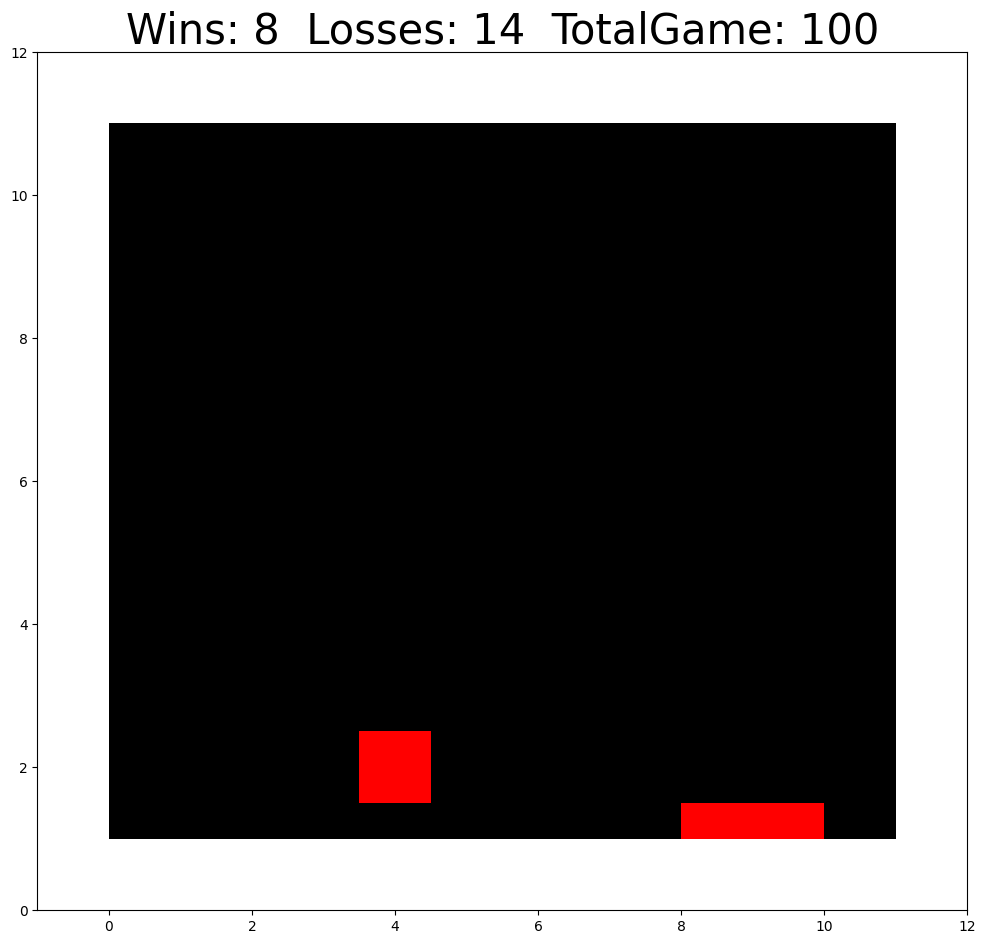

In [57]:
ground = 1
plot = pl.figure(figsize=(12,12))
axis = plot.add_subplot(111, aspect='equal')
axis.set_xlim([-1, 12])
axis.set_ylim([0, 12])

saver = tf.compat.v1.train.Saver()

def drawState(fruitRow, fruitColumn, basket):
    global gridSize
      # column is the x axis
    fruitX = fruitColumn 
      # Invert matrix style points to coordinates
    fruitY = (gridSize - fruitRow + 1)
    statusTitle = "Wins: " + str(winCount) + "  Losses: " + str(loseCount) + "  TotalGame: " + str(numberOfGames)
    axis.set_title(statusTitle, fontsize=30)
    for p in [
        patches.Rectangle(
            ((ground - 1), (ground)), 11, 10, facecolor="#000000"      # Black
        ),
        patches.Rectangle(
            (basket - 1, ground), 2, 0.5, facecolor="#FF0000"     # No background
        ),
        patches.Rectangle(
            (fruitX - 0.5, fruitY - 0.5), 1, 1, facecolor="#FF0000"       # red 
        ),   
        ]:
        axis.add_patch(p)
    display.clear_output(wait=True)
    display.display(pl.gcf())

with tf.compat.v1.Session() as sess:    
    # Restore variables from disk.
    saver.restore(sess, 'model')
    print('saved model is loaded!')

    while (numberOfGames < maxGames):
        numberOfGames = numberOfGames + 1
     
    # The initial state of the environment.
    isGameOver = False
    fruitRow, fruitColumn, basket = env.reset()
    currentState = env.observe()
    drawState(fruitRow, fruitColumn, basket)

    while (isGameOver != True):
        # Forward the current state through the network.
        q = sess.run(output_layer, feed_dict={X: currentState})
        # Find the max index (the chosen action).
        index = q.argmax()
        action = index + 1
        nextState, reward, gameOver, stateInfo = env.act(action)    
        fruitRow = stateInfo[0]
        fruitColumn = stateInfo[1]
        basket = stateInfo[2]
     
        # Count game results
        if (reward == 1):
            winCount = winCount + 1
        elif (reward == -1):
            loseCount = loseCount + 1

        currentState = nextState
        isGameOver = gameOver
        drawState(fruitRow, fruitColumn, basket)
        time.sleep(0.4)

display.clear_output(wait=True)